## Unsupervised tests on codebook

In [3]:
from src.preprocessing.preprocess_ucr import UCRDatasetImporter
from src.preprocessing.data_pipeline import build_data_pipeline
from src.utils import load_yaml_param_settings
from src.models.vqvae_classification import BaseVQVAE, remap_clusters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import umap
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

### Embedding models:

In [4]:
class UMAP_model:
    def __init__(self, model, n_comps=2): 
        self.model = model
        self.reducer = umap.UMAP(n_components=n_comps)

    def fit(self, x_train, y_labs):
        train_embs = self.reducer.fit_transform(x_train)
        self.model.fit(train_embs, y_labs)

    def predict(self, x_test):
        test_embs = self.reducer.transform(x_test)
        return self.model.predict(test_embs)

class PCA_model:
    def __init__(self, model, var_explained_crit=0.9): 
        self.model = model
        self.pca = PCA(var_explained_crit)

    def fit(self, x_train, y_labs):
        train_embs = self.pca.fit_transform(x_train)
        self.model.fit(train_embs, y_labs)

    def predict(self, x_test):
        test_embs = self.pca.transform(x_test)
        preds = self.model.predict(test_embs)
        return preds

#### Visualiser

In [5]:
def UMAP_plots(X_test, labs_pred, labs_true):
    dens_mapper = umap.UMAP(densmap=True, n_components=2)
    embs = dens_mapper.fit_transform(X_test)


    f, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].scatter(embs[:, 0], embs[:, 1], c=labs_true); ax[0].set_title("true")
    ax[1].scatter(embs[:, 0], embs[:, 1], c=labs_pred); ax[1].set_title("predicted")

## Constructing VQVAE based on config

In [6]:
config_dir = 'src/configs/config.yaml' #dir to config file

config = load_yaml_param_settings(config_dir)

# data pipeline
dataset_importer = UCRDatasetImporter(**config['dataset'])
batch_size = config['dataset']['batch_sizes']['vqvae']
train_data_loader, test_data_loader = [build_data_pipeline(batch_size, dataset_importer, config, kind) for kind in ['train', 'test']]

input_length = train_data_loader.dataset.X.shape[-1]

vqvae = BaseVQVAE(input_length, config)

self.X_train.shape: (30, 128)
self.X_test.shape: (900, 128)
# unique labels (train): [0 1 2]
# unique labels (test): [0 1 2]


## Grabbing data. 
train and test dataloader sent through VQVAE's encoder and codebook. Generates lists of discrete latent variables.

In [7]:
zqs_train, _ = vqvae.run_through_codebook(train_data_loader)
y_train = train_data_loader.dataset.Y.flatten().astype(int)

zqs_test, _ = vqvae.run_through_codebook(test_data_loader)
y_test = test_data_loader.dataset.Y.flatten().astype(int)

#scaling:
scaler = StandardScaler()
zqs_train_scaled = scaler.fit_transform(zqs_train)
zqs_test_scaled = scaler.fit_transform(zqs_test)

zqs = np.concatenate((zqs_test, zqs_train), axis=0)
y = np.concatenate((y_test, y_train), axis=0)

zqs_scaled = scaler.fit_transform(zqs)

test_size = 0.2
Z_train, Z_test, Y_train, Y_test = train_test_split(zqs, y, test_size=test_size)
Z_train_scaled, Z_test_scaled, Y_train2, Y_test2 = train_test_split(zqs_scaled, y, test_size=test_size)

# Testing models

## KNN

In [8]:
k = len(np.unique(y_train))

neigh = KNeighborsClassifier(n_neighbors=k)

neigh.fit(zqs_train_scaled, y_train)

y_pred_knn = neigh.predict(zqs_test_scaled)

print("Accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred_knn))

Accuracy: 0.2722222222222222


on splitted dataset

In [9]:
neigh = KNeighborsClassifier(n_neighbors=k)

neigh.fit(Z_train_scaled, Y_train2)

Y_pred_knn = neigh.predict(Z_test_scaled)

print("Accuracy:", metrics.accuracy_score(y_true=Y_test2, y_pred=Y_pred_knn))

Accuracy: 0.9354838709677419


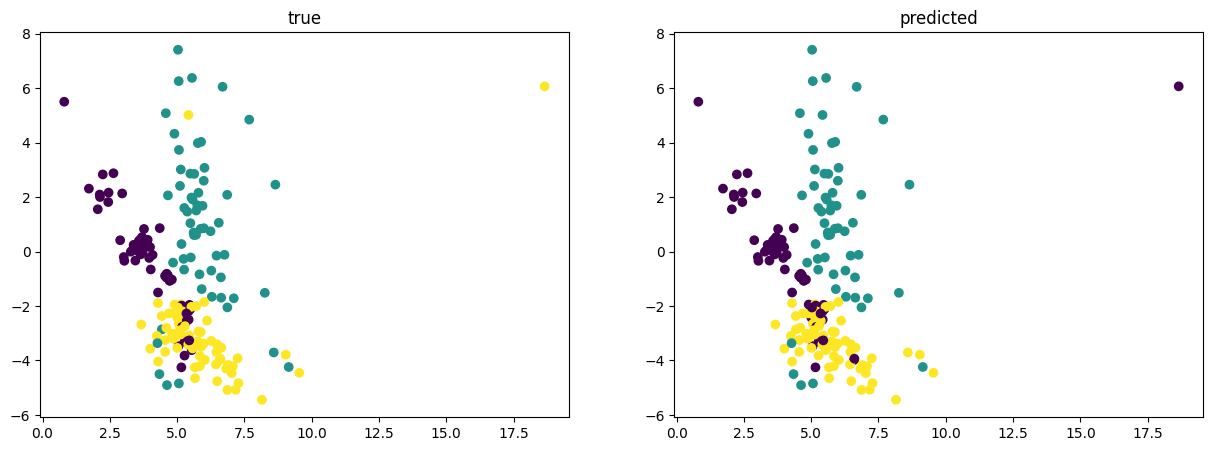

In [10]:
UMAP_plots(Z_test_scaled, Y_pred_knn, Y_test2)

In [190]:
pca_neigh = PCA_model(KNeighborsClassifier(n_neighbors=k), var_explained_crit=0.95)
umap_neigh = UMAP_model(KNeighborsClassifier(n_neighbors=k), n_comps = 10)

pca_neigh.fit(Z_train_scaled, Y_train2)
umap_neigh.fit(Z_train, Y_train2)


y_pca_neigh_pred = pca_neigh.predict(Z_test_scaled)
y_umap_neigh_pred = umap_neigh.predict(Z_test_scaled)

print("Acc pca knn:", metrics.accuracy_score(y_true=Y_test2, y_pred=y_pca_neigh_pred))
print("Acc umap knn:", metrics.accuracy_score(y_true=Y_test2, y_pred=y_umap_neigh_pred))

Acc pca knn: 0.8921568627450981
Acc umap knn: 0.2107843137254902


## SVM

In [11]:
svm = SVC(kernel='linear')
svm.fit(zqs_train_scaled, y_train)
y_pred_svm = svm.predict(zqs_test_scaled)
print("Accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred_svm))

Accuracy: 0.2822222222222222


On splitted dataset

In [13]:
svm = SVC(kernel='linear')
svm.fit(Z_train_scaled, Y_train2)
Y_pred_svm = svm.predict(Z_test_scaled)

print("Accuracy:", metrics.accuracy_score(y_true=Y_test2, y_pred=Y_pred_svm))

Accuracy: 0.956989247311828


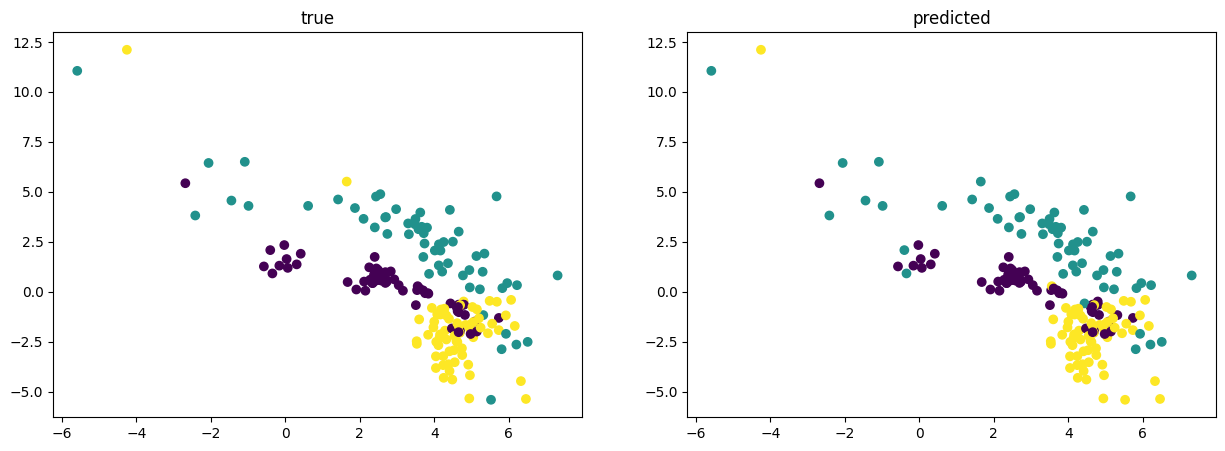

In [14]:
UMAP_plots(Z_test_scaled, Y_pred_svm, Y_test2)

In [193]:
pca_svm = PCA_model(SVC(kernel='linear'), var_explained_crit=0.95)
umap_svm = UMAP_model(SVC(kernel='linear'), n_comps = 20)

pca_svm.fit(Z_train_scaled, Y_train2)
umap_svm.fit(Z_train_scaled, Y_train2)


y_pca_svm_pred = pca_svm.predict(Z_test_scaled)
y_umap_svm_pred = umap_svm.predict(Z_test_scaled)

print("Acc pca knn:", metrics.accuracy_score(y_true=Y_test2, y_pred=y_pca_svm_pred))
print("Acc umap knn:", metrics.accuracy_score(y_true=Y_test2, y_pred=y_umap_svm_pred))

Acc pca knn: 0.8382352941176471
Acc umap knn: 0.8333333333333334


## Linear discriminant analysis

In [16]:
clf = LinearDiscriminantAnalysis()
clf.fit(zqs_train_scaled, y_train)

y_pred_lda = clf.predict(zqs_test)

print("accuracy:", metrics.accuracy_score(y_pred=y_pred_lda, y_true=y_test))

accuracy: 0.24666666666666667


on splitted dataset

In [17]:
clf2 = LinearDiscriminantAnalysis()
clf2.fit(Z_train_scaled, Y_train2)

Y_pred_lda = clf2.predict(Z_test_scaled)

print("accuracy:", metrics.accuracy_score(y_pred=Y_pred_lda, y_true=Y_test2))

accuracy: 0.9408602150537635


In [18]:
pca_lda = PCA_model(LinearDiscriminantAnalysis(), var_explained_crit=0.95)
umap_lda = UMAP_model(LinearDiscriminantAnalysis(), n_comps = 20)

pca_lda.fit(Z_train_scaled, Y_train2)
umap_lda.fit(Z_train_scaled, Y_train2)


y_pca_lda_pred = pca_lda.predict(Z_test_scaled)
y_umap_lda_pred = umap_lda.predict(Z_test_scaled)

print("Acc pca knn:", metrics.accuracy_score(y_true=Y_test2, y_pred=y_pca_lda_pred))
print("Acc umap knn:", metrics.accuracy_score(y_true=Y_test2, y_pred=y_umap_lda_pred))

Acc pca knn: 0.9838709677419355
Acc umap knn: 0.9032258064516129


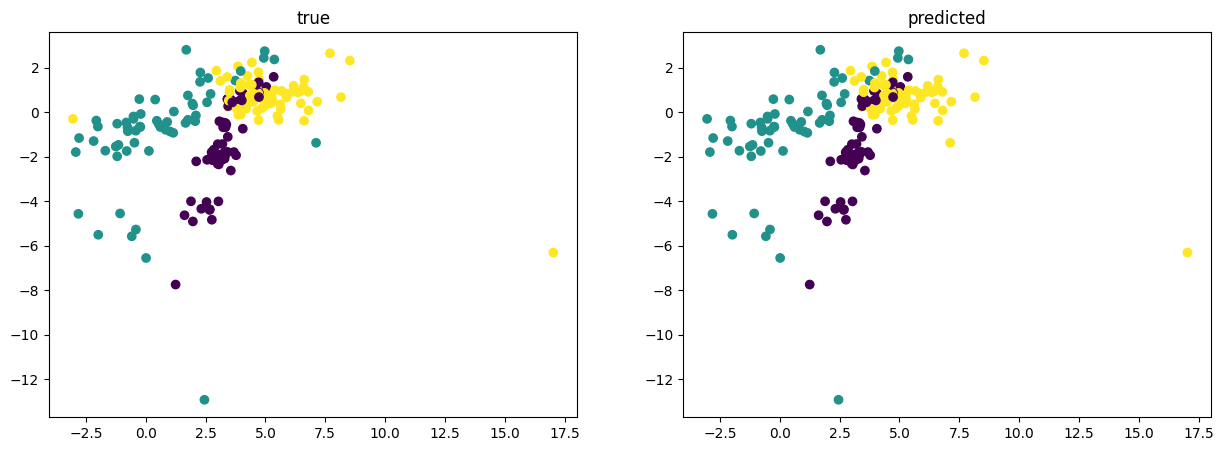

In [19]:
UMAP_plots(Z_test_scaled, y_pca_lda_pred, Y_test2)